# Garbage Classification — Data Preprocessing & Inspection

In this notebook, we will perform the full **data preprocessing and inspection** steps to make the dataset ready for modeling.  
We aim to satisfy the following criteria:

- Load & inspect the dataset (≈ 13.9k images)  
- Confirm the 6 classes (`plastic`, `metal`, `glass`, `cardboard`, `paper`, `trash`)  
- Verify class balance (≈ 2,300–2,500 images per class)  
- Detect (and optionally remove or flag) duplicates  
- Confirm image sizes and color channels (expected: 256×256, 3 channels RGB)  
- Ensure labels align correctly with image files  
- Split into train / validation / (test) sets, with stratification  
- Normalize / standardize pixel values (record method)  
- (Optional) Set up data augmentation  
- Build a pipeline or loader to ensure a batch can go through a baseline CNN  

We’ll break this into sections.

---

# Step 0: Download Kaggle Garbage Images Dataset


In [1]:
from google.colab import files
# Upload your kaggle.json
    # Only needs to be done once
    # If you have not uploaded kaggle.json file here before,
        # follow instructions below on acquiring kaggle.json
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!pip install -q kaggle

import os

# Make sure the Kaggle API key is available
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("UPLOAD KAGGLE.JSON FILE ABOVE")
    print("WATCH VIDEO I (AGUSTIN) SENT IN GROUP CHAT ON GETTING KAGGLE.JSON")

# Create data directory if not exists
os.makedirs("data", exist_ok=True)

# Download + unzip only if not already present
if not os.path.exists("data/Garbage_Dataset_Classification"):
    !kaggle datasets download -d zlatan599/garbage-dataset-classification -p data/
    !unzip -q data/garbage-dataset-classification.zip -d data/
    print("Dataset downloaded and extracted!")
else:
    print("Dataset already exists, skipping download.")

Dataset URL: https://www.kaggle.com/datasets/zlatan599/garbage-dataset-classification
License(s): MIT
  0% 0.00/121M [00:00<?, ?B/s]
100% 121M/121M [00:00<00:00, 1.66GB/s]
Dataset downloaded and extracted!


# Step 1: Setup & Imports (install if not already done)

In [3]:
%pip install imagededup

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 14.4 MB/s eta 0:00:00


In [4]:
# Required libraries
import os
from pathlib import Path
from collections import Counter
import random
import hashlib

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# For splitting
from sklearn.model_selection import train_test_split

# For dedup
from imagededup.methods import PHash

# Step 2: Define dataset root & discover classes

In [5]:
dataset_root = Path("data/Garbage_Dataset_Classification/images")

assert dataset_root.exists(), f"Dataset root not found: {dataset_root}"

# List subdirectories as candidate classes
classes = [d.name for d in dataset_root.iterdir() if d.is_dir()]
classes = sorted(classes)
print("Found classes:", classes)

Found classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# Step 3: Confirm expected classes & label consistency

In [6]:
expected = {"plastic", "metal", "glass", "cardboard", "paper", "trash"}
found = set(classes)
print("Expected classes:", expected)
print("Found classes:", found)

if found == expected:
    print("The classes match exactly the expected ones.")
else:
    print("Class mismatch.")
    print("Missing:", expected - found)
    print("Extra:", found - expected)


Expected classes: {'trash', 'metal', 'glass', 'plastic', 'cardboard', 'paper'}
Found classes: {'metal', 'plastic', 'paper', 'trash', 'glass', 'cardboard'}
The classes match exactly the expected ones.


# Step 4: Count images per class & class balance

In [7]:
# Supported Extensions
SUPPORTED_EXTS = (".jpg", ".jpeg", ".png")

class_counts = {}
for cls in classes:
    cls_dir = dataset_root / cls
    imgs = []
    for ext in SUPPORTED_EXTS:
        imgs.extend(list(cls_dir.glob(f"*{ext}")))
    # Also check for any unexpected extensions
    other = list(cls_dir.glob("*"))
    others = [p for p in other if p.suffix.lower() not in SUPPORTED_EXTS]
    if others:
        print(f"Warning: found {len(others)} files in {cls} with unexpected extension(s): {set(p.suffix for p in others)}")
    class_counts[cls] = len(imgs)

print("Counts per class:")
for cls, cnt in class_counts.items():
    print(f"  {cls}: {cnt}")
counts = np.array(list(class_counts.values()))
print("Total images:", counts.sum())
print("Min , Max , Mean:", counts.min(), ",", counts.max(), ",", counts.mean())


Counts per class:
  cardboard: 2214
  glass: 2500
  metal: 2084
  paper: 2315
  plastic: 2288
  trash: 2500
Total images: 13901
Min , Max , Mean: 2084 , 2500 , 2316.8333333333335


# Step 5: Duplicate Detection, Preview & Cleaned Copy (change path in code block)

2025-10-12 14:35:52,833: INFO Start: Calculating hashes...
INFO:imagededup.methods.hashing:Start: Calculating hashes...


Encoding class: cardboard


100%|██████████| 2214/2214 [00:04<00:00, 508.28it/s]
2025-10-12 14:35:57,475: INFO End: Calculating hashes!
INFO:imagededup.methods.hashing:End: Calculating hashes!
/usr/local/lib/python3.12/dist-packages/imagededup/methods/hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)
2025-10-12 14:35:57,481: INFO Start: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:Start: Evaluating hamming distances for getting duplicates
2025-10-12 14:35:57,483: INFO Start: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 2214/2214 [00:05<00:00, 429.02it/s]
2025-10-12 14:36:02,780: INFO End: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.searc

  1071 keys have duplicates in cardboard
Encoding class: glass


100%|██████████| 2500/2500 [00:06<00:00, 399.90it/s]
2025-10-12 14:36:09,410: INFO End: Calculating hashes!
INFO:imagededup.methods.hashing:End: Calculating hashes!
2025-10-12 14:36:09,419: INFO Start: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:Start: Evaluating hamming distances for getting duplicates
2025-10-12 14:36:09,426: INFO Start: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 2500/2500 [00:03<00:00, 644.52it/s]
2025-10-12 14:36:13,417: INFO End: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:End: Retrieving duplicates using Cython Brute force algorithm
2025-10-12 14:36:13,428: INFO End: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:End: Evaluating hamming distances for getting duplicates
2025-10-12 14:36:13,513: INFO 

  591 keys have duplicates in glass
Encoding class: metal


100%|██████████| 2084/2084 [00:05<00:00, 406.77it/s]
2025-10-12 14:36:18,901: INFO End: Calculating hashes!
INFO:imagededup.methods.hashing:End: Calculating hashes!
2025-10-12 14:36:18,904: INFO Start: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:Start: Evaluating hamming distances for getting duplicates
2025-10-12 14:36:18,906: INFO Start: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 2084/2084 [00:01<00:00, 1378.63it/s]
2025-10-12 14:36:20,470: INFO End: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:End: Retrieving duplicates using Cython Brute force algorithm
2025-10-12 14:36:20,471: INFO End: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:End: Evaluating hamming distances for getting duplicates
2025-10-12 14:36:20,496: INFO

  925 keys have duplicates in metal
Encoding class: paper


100%|██████████| 2315/2315 [00:02<00:00, 782.14it/s]
2025-10-12 14:36:23,638: INFO End: Calculating hashes!
INFO:imagededup.methods.hashing:End: Calculating hashes!
2025-10-12 14:36:23,641: INFO Start: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:Start: Evaluating hamming distances for getting duplicates
2025-10-12 14:36:23,643: INFO Start: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 2315/2315 [00:01<00:00, 1224.49it/s]
2025-10-12 14:36:25,587: INFO End: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:End: Retrieving duplicates using Cython Brute force algorithm
2025-10-12 14:36:25,589: INFO End: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:End: Evaluating hamming distances for getting duplicates
2025-10-12 14:36:25,613: INFO

  1150 keys have duplicates in paper
Encoding class: plastic


100%|██████████| 2288/2288 [00:03<00:00, 615.39it/s]
2025-10-12 14:36:29,568: INFO End: Calculating hashes!
INFO:imagededup.methods.hashing:End: Calculating hashes!
2025-10-12 14:36:29,572: INFO Start: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:Start: Evaluating hamming distances for getting duplicates
2025-10-12 14:36:29,575: INFO Start: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 2288/2288 [00:02<00:00, 818.29it/s] 
2025-10-12 14:36:32,435: INFO End: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:End: Retrieving duplicates using Cython Brute force algorithm
2025-10-12 14:36:32,436: INFO End: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:End: Evaluating hamming distances for getting duplicates
2025-10-12 14:36:32,463: INFO

  1309 keys have duplicates in plastic
Encoding class: trash


100%|██████████| 2500/2500 [00:03<00:00, 772.69it/s]
2025-10-12 14:36:35,937: INFO End: Calculating hashes!
INFO:imagededup.methods.hashing:End: Calculating hashes!
2025-10-12 14:36:35,940: INFO Start: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:Start: Evaluating hamming distances for getting duplicates
2025-10-12 14:36:35,941: INFO Start: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 2500/2500 [00:02<00:00, 1167.14it/s]
2025-10-12 14:36:38,136: INFO End: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:End: Retrieving duplicates using Cython Brute force algorithm
2025-10-12 14:36:38,138: INFO End: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:End: Evaluating hamming distances for getting duplicates


  4 keys have duplicates in trash

Total duplicate pairs found: 5232


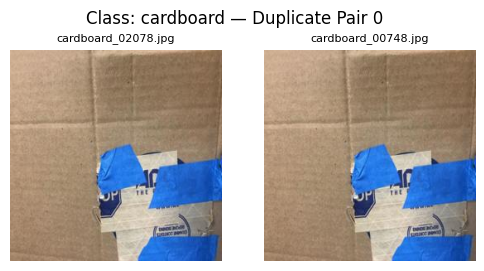

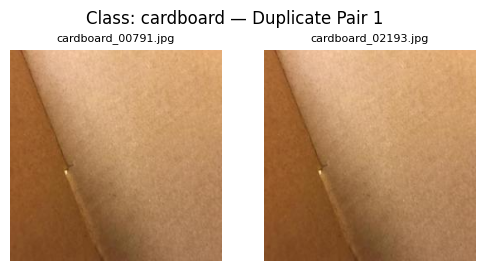

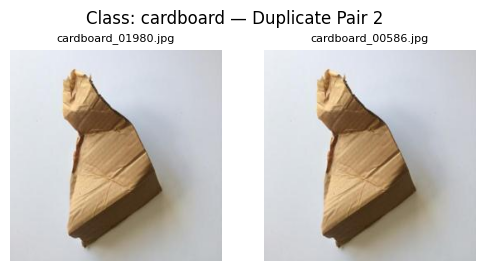

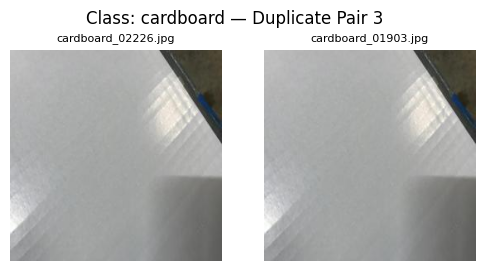

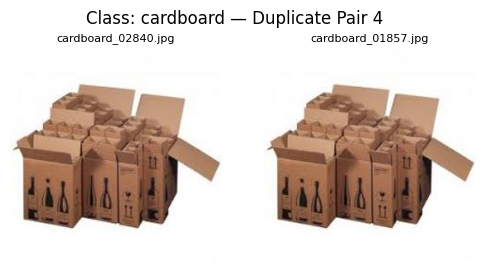

Total duplicate files to remove: 5050

Class counts BEFORE cleaning:
  cardboard: 2214
  glass: 2500
  metal: 2084
  paper: 2315
  plastic: 2288
  trash: 2500

Class counts AFTER cleaning:
  cardboard: 1143
  glass: 1909
  metal: 1159
  paper: 1165
  plastic: 979
  trash: 2496

 Cleaned dataset created at: data/Garbage_Dataset_Classification/images_cleaned


In [8]:
import shutil
from imagededup.methods import PHash

# 1. Run imagededup PHash per class
ph = PHash()
dups_all = {}

for cls in classes:
    cls_dir = dataset_root / cls
    print(f"Encoding class: {cls}")
    encodings = ph.encode_images(image_dir=str(cls_dir), recursive=False)
    dups = ph.find_duplicates(encoding_map=encodings, max_distance_threshold=3)
    dups_all[cls] = dups
    n_dup_keys = len([k for k, v in dups.items() if v])
    print(f"  {n_dup_keys} keys have duplicates in {cls}")

# 2. Collect duplicate pairs across all classes
def collect_duplicate_pairs(dups_dict, cls):
    pairs = []
    for fname, dup_list in dups_dict.items():
        for dup in dup_list:
            pairs.append((cls, fname, dup))
    return pairs

all_pairs = []
for cls, dups in dups_all.items():
    all_pairs.extend(collect_duplicate_pairs(dups, cls))

print(f"\nTotal duplicate pairs found: {len(all_pairs)}")

# 3. Preview first 5 duplicate pairs
def preview_duplicate_pairs(pairs, n=5):
    for idx, (cls, f1, f2) in enumerate(pairs[:n]):
        path1 = dataset_root / cls / f1
        path2 = dataset_root / cls / f2

        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        try:
            img1 = Image.open(path1)
            img2 = Image.open(path2)

            axes[0].imshow(img1)
            axes[0].set_title(f"{f1}", fontsize=8)
            axes[0].axis("off")

            axes[1].imshow(img2)
            axes[1].set_title(f"{f2}", fontsize=8)
            axes[1].axis("off")

            plt.suptitle(f"Class: {cls} — Duplicate Pair {idx}")
            plt.show()
        except Exception as e:
            print(f"Error loading {f1}, {f2}:", e)

preview_duplicate_pairs(all_pairs, n=5)

# 4. Build cleaned dataset copy
cleaned_root = Path("data/Garbage_Dataset_Classification/images_cleaned")
cleaned_root.mkdir(parents=True, exist_ok=True)

# Mark duplicates to remove (always second file in pair)
to_remove = set([p[2] for p in all_pairs])
print("Total duplicate files to remove:", len(to_remove))

# Before counts
print("\nClass counts BEFORE cleaning:")
for cls in classes:
    total = sum(len(list((dataset_root/cls).glob(f"*{ext}"))) for ext in SUPPORTED_EXTS)
    print(f"  {cls}: {total}")

# Copy files, skipping duplicates
for cls in classes:
    src_dir = dataset_root / cls
    dst_dir = cleaned_root / cls
    dst_dir.mkdir(parents=True, exist_ok=True)

    for ext in SUPPORTED_EXTS:
        for file in src_dir.glob(f"*{ext}"):
            if file.name not in to_remove:
                shutil.copy(file, dst_dir / file.name)

# After counts
print("\nClass counts AFTER cleaning:")
for cls in classes:
    total = sum(len(list((cleaned_root/cls).glob(f"*{ext}"))) for ext in SUPPORTED_EXTS)
    print(f"  {cls}: {total}")

print("\n Cleaned dataset created at:", cleaned_root)


# Step 6: Confirm Image Sizes and Color Channels

In [9]:
shape_counter = Counter()
channel_counter = Counter()
bad_images = []

for cls in classes:
    cls_dir = cleaned_root / cls
    for ext in SUPPORTED_EXTS:
        for p in cls_dir.glob(f"*{ext}"):
            try:
                with Image.open(p) as img:
                    arr = np.array(img)
                shape_counter[arr.shape] += 1
                if arr.ndim == 3:
                    channel_counter[arr.shape[2]] += 1
                else:
                    channel_counter[1] += 1
            except Exception as e:
                bad_images.append((p, str(e)))

print("Image shape distribution (H, W, [C]):")
for shp, cnt in shape_counter.items():
    print(f"  {shp}: {cnt} images")

print("\nChannel counts:")
for c, cnt in channel_counter.items():
    print(f"  {c} channels: {cnt} images")

print("\nNumber of images that failed to load:", len(bad_images))
if bad_images:
    print("Sample failed images:", bad_images[:5])

Image shape distribution (H, W, [C]):
  (256, 256, 3): 8851 images

Channel counts:
  3 channels: 8851 images

Number of images that failed to load: 0


# Step 7: Verify Labels Align with Images (using metadata.csv)

In [10]:
import pandas as pd

# 1. Verify every image in cleaned_root is inside the expected class folder
problems = []
for cls in classes:
    cls_dir = cleaned_root / cls
    for ext in SUPPORTED_EXTS:
        for p in cls_dir.glob(f"*{ext}"):
            if p.parent.name != cls:
                problems.append((p, p.parent.name, cls))

if problems:
    print(f"Found {len(problems)} images in the wrong folder:")
    print(problems[:10])
else:
    print("All images are in the correct class folders.")

# 2. Cross-check with metadata.csv located at the dataset's parent folder
metadata_path = dataset_root.parent / "metadata.csv"

if metadata_path.exists():
    meta = pd.read_csv(metadata_path)
    meta_map = dict(zip(meta.filename, meta.label))

    mismatches = []
    for cls in classes:
        cls_dir = cleaned_root / cls
        for ext in SUPPORTED_EXTS:
            for p in cls_dir.glob(f"*{ext}"):
                fname = p.name
                if fname in meta_map and meta_map[fname] != cls:
                    mismatches.append((fname, cls, meta_map[fname]))

    if mismatches:
        print(f"Found {len(mismatches)} mismatches with metadata.csv:")
        print(mismatches[:10])
    else:
        print("Folder labels match metadata.csv for all files checked.")
else:
    print("metadata.csv not found at:", metadata_path)

All images are in the correct class folders.
Folder labels match metadata.csv for all files checked.


# Step 8: Stratified Split using StratifiedShuffleSplit (80/10/10)

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

# Rebuild data list from cleaned dataset
data = []
for cls in classes:
    cls_dir = cleaned_root / cls
    for ext in SUPPORTED_EXTS:
        for p in cls_dir.glob(f"*{ext}"):
            data.append((p, cls))

print("Total cleaned samples:", len(data))

paths = [p for p, lbl in data]
labels = [lbl for p, lbl in data]

# Choose your split ratios
test_ratio = 0.10
val_ratio = 0.10
train_ratio = 1.0 - (test_ratio + val_ratio)
assert train_ratio > 0, "Make sure ratios sum to less than 1"

# 1. Split off test set
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=42)
for train_valid_idx, test_idx in sss.split(paths, labels):
    pass

train_valid_paths = [paths[i] for i in train_valid_idx]
train_valid_labels = [labels[i] for i in train_valid_idx]
test_paths = [paths[i] for i in test_idx]
test_labels = [labels[i] for i in test_idx]

# 2. Split train_valid into train + validation
rel_val = val_ratio / (train_ratio + val_ratio)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=rel_val, random_state=42)
for train_idx2, val_idx in sss2.split(train_valid_paths, train_valid_labels):
    pass

train_paths = [train_valid_paths[i] for i in train_idx2]
train_labels = [train_valid_labels[i] for i in train_idx2]
val_paths = [train_valid_paths[i] for i in val_idx]
val_labels = [train_valid_labels[i] for i in val_idx]

# Build final splits
train_set = list(zip(train_paths, train_labels))
valid_set = list(zip(val_paths, val_labels))
test_set = list(zip(test_paths, test_labels))

# Print sizes
print("Total:", len(data))
print("Train:", len(train_set), "Validation:", len(valid_set), "Test:", len(test_set))
print()

def print_dist(split, name):
    c = Counter(lbl for _, lbl in split)
    print(f"{name} class counts:")
    for cls in classes:
        print(f"  {cls}: {c.get(cls, 0)}")
    print()

print_dist(train_set, "Train")
print_dist(valid_set, "Validation")
print_dist(test_set, "Test")


Total cleaned samples: 8851
Total: 8851
Train: 7079 Validation: 886 Test: 886

Train class counts:
  cardboard: 915
  glass: 1527
  metal: 927
  paper: 931
  plastic: 783
  trash: 1996

Validation class counts:
  cardboard: 114
  glass: 191
  metal: 116
  paper: 117
  plastic: 98
  trash: 250

Test class counts:
  cardboard: 114
  glass: 191
  metal: 116
  paper: 117
  plastic: 98
  trash: 250



# Step 9: Build PyTorch dataset & transforms (normalize + augment)

In [12]:
!pip install -q torch torchvision

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os

# Map class names to integer labels (sorted to be consistent)
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Transforms
# Train: light augmentations + normalize (ImageNet mean/std)
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=224, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

# Val/Test: center crop + normalize (no augmentation)
eval_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

class GarbageDataset(Dataset):
    def __init__(self, items, transform=None):
        """
        items: list of (Path, class_name)
        """
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, cls_name = self.items[idx]
        label = class_to_idx[cls_name]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label, str(path)


# Step 10: Address class imbalance after cleaning (class weights or weighted sampler)

In [13]:
# Compute class counts from the TRAIN split
train_class_counts = Counter(lbl for _, lbl in train_set)
print("Train class counts:", train_class_counts)

# Option A: Class weights for CrossEntropyLoss: weight the loss function so false prediction on classes with fewer sample are harsher
num_classes = len(classes)
counts = np.array([train_class_counts[c] for c in classes], dtype=np.float32)
class_weights = counts.sum() / (num_classes * counts)  # inverse-frequency-ish
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print("Class weights (A):", class_weights)

# Option B: WeightedRandomSampler: classes with fewer sample are more likely to be chosen thus balance out class distribution
label_to_idx = class_to_idx
per_class_weight = {cls: (counts.sum() / (num_classes * cnt))
                    for cls, cnt in train_class_counts.items()}
sample_weights = [per_class_weight[lbl] for _, lbl in train_set]
sampler = WeightedRandomSampler(weights=torch.DoubleTensor(sample_weights),
                                num_samples=len(sample_weights),
                                replacement=True)


Train class counts: Counter({'trash': 1996, 'glass': 1527, 'paper': 931, 'metal': 927, 'cardboard': 915, 'plastic': 783})
Class weights (A): [1.2894354  0.7726479  1.2727436  1.2672753  1.5068114  0.59109885]


# Step 11: DataLoaders (with augmentation on train)

In [14]:
# Datasets
train_ds = GarbageDataset(train_set, transform=train_tfms)
val_ds   = GarbageDataset(valid_set, transform=eval_tfms)
test_ds  = GarbageDataset(test_set,  transform=eval_tfms)

# DataLoaders: manage sampler, batch size, etc.
BATCH_SIZE = 32
num_workers = 2 if "COLAB_GPU" in os.environ or "COLAB_TPU_ADDR" in os.environ else 0

use_weighted_sampler = True  # set False if we want to do option A

if use_weighted_sampler:
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              sampler=sampler, num_workers=num_workers, pin_memory=True)
else:
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=num_workers, pin_memory=True)

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=num_workers, pin_memory=True)

print("Batches -> train:", len(train_loader), "val:", len(val_loader), "test:", len(test_loader))

Batches -> train: 222 val: 28 test: 28


# Step 12: Visualize one preprocessed + augmented batch



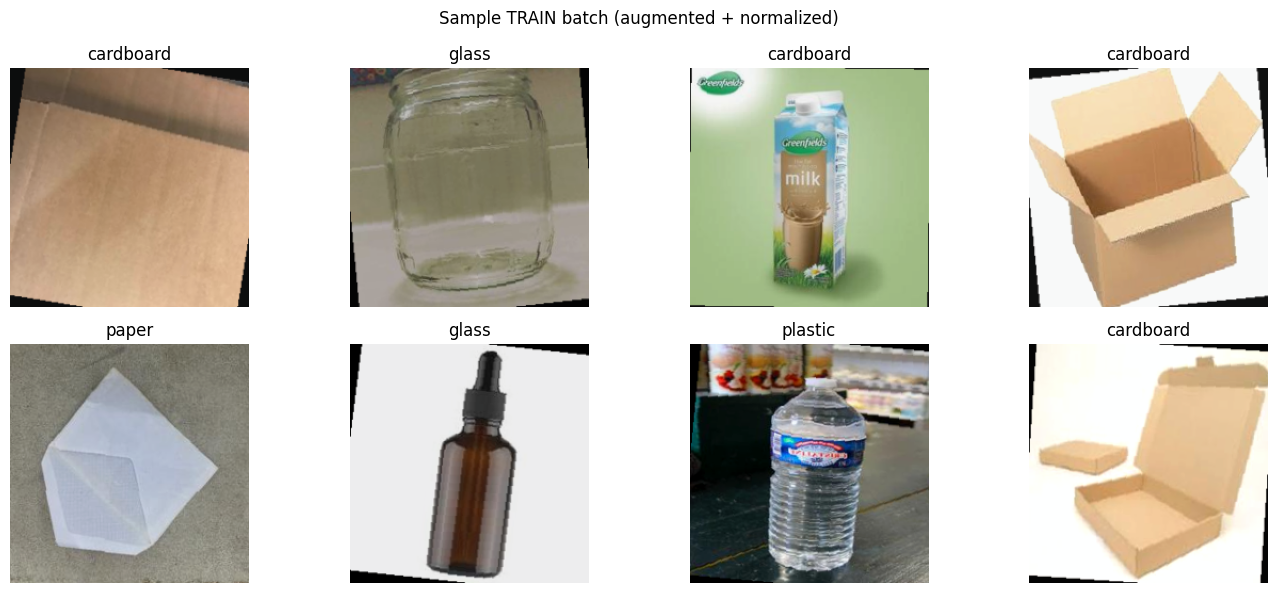

In [15]:
# Helper to denormalize ImageNet-normalized tensors for display
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    img = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    img = (img * IMAGENET_STD) + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

# Get one batch
imgs, labels, paths = next(iter(train_loader))

# Plot first 8
n_show = min(8, imgs.size(0))
plt.figure(figsize=(14, 6))
for i in range(n_show):
    plt.subplot(2, 4, i+1)
    plt.imshow(denormalize(imgs[i]))
    plt.title(idx_to_class[int(labels[i])])
    plt.axis("off")
plt.suptitle("Sample TRAIN batch (augmented + normalized)")
plt.tight_layout()
plt.show()

# Step 13: Document split shapes (train/val/test per class)

In [16]:
def class_dist(items, title):
    c = Counter(lbl for _, lbl in items)
    print(title)
    for cls in classes:
        print(f"  {cls:9s}: {c.get(cls,0)}")
    print("  TOTAL    :", sum(c.values()))
    print()

class_dist(train_set, "TRAIN distribution")
class_dist(valid_set, "VALID distribution")
class_dist(test_set,  "TEST  distribution")


TRAIN distribution
  cardboard: 915
  glass    : 1527
  metal    : 927
  paper    : 931
  plastic  : 783
  trash    : 1996
  TOTAL    : 7079

VALID distribution
  cardboard: 114
  glass    : 191
  metal    : 116
  paper    : 117
  plastic  : 98
  trash    : 250
  TOTAL    : 886

TEST  distribution
  cardboard: 114
  glass    : 191
  metal    : 116
  paper    : 117
  plastic  : 98
  trash    : 250
  TOTAL    : 886



# Step 14: Pipeline readiness: push one batch through ResNet18

In [17]:
# Load a baseline CNN and run a single forward pass to confirm pipeline is ready
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# starting from scratch
# later we can use pretrained weights for TL
model = models.resnet18(weights=None)
# Adapt the final layer to 6 classes
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

# One forward pass
model.eval()
with torch.no_grad():
    xb, yb, _ = next(iter(train_loader))
    xb = xb.to(device)
    yb = yb.to(device)
    logits = model(xb)
    print("Forward OK -> logits shape:", logits.shape)

Device: cuda
Forward OK -> logits shape: torch.Size([32, 6])


# Step 15: MobileNetV2 Architecture

In [18]:
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.notebook import tqdm


# Depthwise Separable Convolution (used inside rInverted Residual)
class Conv_BN_ReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):

        padding = (kernel_size - 1) // 2 # to preserve original size if stride = 1

        super().__init__(
            # If group = 1, it's standard convolution (1 filter for entire depth)
            # if groups = in_channels it's depthwise convolution (1 filter per layer)
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True) # ReLU that clips value to be between [0, 6]
        )

# Inverted Residual Block
class Inverted_Residual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        # expand ratio control how much we expand channels before depthwise conv.
        '''more channels/hidden_dim means more depth/layers or feature maps produced during 3x3 depthwise conv. means richer representation for learning'''
        hidden_dim = in_channels * expand_ratio

        '''a boolean that determine if residual short cut is applied at the end'''
        self.use_res_connect = (stride == 1 and in_channels == out_channels)

        layers = []
        if expand_ratio != 1:
            # carry out the expansion from in_channels to hidden_dim size if expand ratio is specified
            layers.append(Conv_BN_ReLU(in_channels, hidden_dim, kernel_size=1))
            '''Narrow -> Wide (recall Invert Residual Block is: Narrow -> Wide -> Narrow)'''

        # applies Depthwise conv, 3x3
        '''since groups=in_channels it means 1 filter per layer = Depthwise conv'''
        layers.append(Conv_BN_ReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim))

        # applies 1x1 conv: communication between depths
        '''compress channels back to low-dimensional space (out_channels)'''
        '''Wide -> Narrow'''
        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        # no ReLU because of linear bottleneck (prevents losing information in compressed representation)

        '''the *layer is same as passing individual element of layer array, it's just easier this way'''
        self.conv = nn.Sequential(*layers)
        # warps the layers into a sequential block

    def forward(self, x):
        if self.use_res_connect:
            # if dimension of in and out channel match at the start
            # adds input to the output here at the end (residual short cut connection)
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    # width_mult to scale channels up/down
    def __init__(self, num_classes=6, width_mult=1.0, dropout_rate=0.2):
        super().__init__()

        inverted_residual_setting = [
            # t (expand ratio), c (channels), n (repeats), s (stride)
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        '''
            t: how much to widen channels inside the block (more channel=more layer/feature map produced during 3x3 depthwise convolution)
            c: number of channels after each projection (output channels)
            n: number of times to repeat the blocks
            s: stride of first block, rest block all have stride = 1 (meaning down sample for first block)
        '''

        input_channel = int(32 * width_mult)
        last_channel = int(1280*width_mult) if width_mult > 1.0 else 1280
        # first conv layer outputs 32 channel scaled by width_mult
        # final conv layer outputs 1280 channel scaled

        '''add first standard 3x3 conv from RGB of 3 channel to 32 channel scaled'''
        features = [Conv_BN_ReLU(in_channels=3, out_channels=input_channel, stride=2)]

        '''loop through each stage Continuously adding layers: Expands -> depthwise -> projects
           apply stride in first block = downsampling, then rest block keep stride=1'''
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult) # Expand
            for i in range(n):
                stride = s if i == 0 else 1 # stride of 1 if not first block
                features.append(Inverted_Residual(input_channel, output_channel, stride, expand_ratio=t)) # depthwise conv. and proj.
                input_channel = output_channel # set the corresponding input channel for next layer

        # add final 1x1 convolution
        features.append(Conv_BN_ReLU(input_channel, last_channel, kernel_size=1))

        # wrap all layer into a sequential block
        self.features = nn.Sequential(*features)

        # define final linear classification layer added in forward function
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes),
        )

        '''initialize weight before forward pass'''
        self._initialize_weights()

    '''define forward pass:
        1 extract features
        2 apply global average pooling
        3 fully connected layer for classification'''
    def forward(self, x):
        x = self.features(x) # continuous feature extraction
        x = x.mean([2, 3])  # Add global average pooling layer
        x = self.classifier(x) # linear layer for final classification
        return x

    # the "_" before function indicates it's an function for internal use
    def _initialize_weights(self):
        '''loop through all layers'''
        for m in self.modules():
            '''check if current layer is either 2D conv. or 2D batch norm. or a fully connected layer'''
            if isinstance(m, nn.Conv2d):
                # value are normally distributed mean of 0 with variance scaled based on number of output unit (fan_out)
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None: # initialize bias if exist in current layer
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                # weight initialize with mean 0 and deviation 0.01
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)




# Step 16: Training and Evaluation Functions

In [19]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns

def model_train(model, train_loader, validation_loader, optimizer, criterion, scheduler, epochs, device):
    # Tracking lists
    epoch_list = []
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_precisions, val_precisions = [], []
    train_recalls, val_recalls = [], []
    train_f1s, val_f1s = [], []

    best_acc = 0.0
    best_f1 = 0.0

    for epoch in range(epochs):
        # ===== TRAINING PHASE =====
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for images, labels, paths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(y_pred, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Calculate training metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))

        # Calculate precision, recall, F1
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='macro', zero_division=0
        )

        # ===== VALIDATION PHASE =====
        val_metrics = model_evaluation(model, validation_loader, criterion, device)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"  Train -> Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% | "
              f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        print(f"  Val   -> Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['accuracy']:.2f}% | "
              f"Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | "
              f"F1: {val_metrics['f1']:.4f}")

        # Store metrics
        epoch_list.append(epoch + 1)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_precisions.append(precision)
        train_recalls.append(recall)
        train_f1s.append(f1)

        val_losses.append(val_metrics['loss'])
        val_accuracies.append(val_metrics['accuracy'])
        val_precisions.append(val_metrics['precision'])
        val_recalls.append(val_metrics['recall'])
        val_f1s.append(val_metrics['f1'])

        scheduler.step()

        # Save best model based on validation F1 score
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            best_acc = val_metrics['accuracy']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': best_f1,
                'val_acc': best_acc,
            }, 'best_model.pth')
            print(f"  ✓ New best model saved! (F1: {best_f1:.4f}, Acc: {best_acc:.2f}%)")

    return {
        'epochs': epoch_list,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_precisions': train_precisions,
        'val_precisions': val_precisions,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'best_f1': best_f1,
        'best_acc': best_acc
    }


def model_evaluation(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels, paths in data_loader:
            images, labels = images.to(device), labels.to(device)
            y_pred = model(images)
            loss = criterion(y_pred, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(y_pred, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate overall metrics
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))

    # Calculate precision, recall, F1 (macro-averaged)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    # Calculate per-class metrics
    per_class_precision, per_class_recall, per_class_f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_class_precision': per_class_precision,
        'per_class_recall': per_class_recall,
        'per_class_f1': per_class_f1,
        'support': support,
        'all_preds': all_preds,
        'all_labels': all_labels
    }

# Step 17: Hyparameters & Training Configuration

In [20]:
# hyper parameter
learning_rate = 0.001
weight_decay = 1e-4
num_epochs = 10
dropout_rate = 0.2

if __name__ == "__main__":
    # Optional warning suppression
    os.environ['PYTHONWARNINGS'] = 'ignore:semaphore_tracker:UserWarning'
    # This ensures proper multiprocessing behavior
    # If using multiprocessing DataLoader
    import sys, torch.multiprocessing as mp
    if sys.platform.startswith("linux"):
        mp.set_start_method('fork', force=True)   # works and fixed your case
    else:
        mp.set_start_method('spawn', force=True)  # safer on macOS/Windows



    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = MobileNetV2(num_classes=6, width_mult=1.0, dropout_rate=dropout_rate).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Optimizer, loss, scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Train model
    print(f"\nStarting training for {num_epochs} epochs...")
    results = model_train(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, device)


    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Best Validation F1: {results['best_f1']:.4f}")
    print(f"Best Validation Accuracy: {results['best_acc']:.2f}%")
    print(f"{'='*60}")

Using device: cuda
Model parameters: 2,231,558

Starting training for 10 epochs...


Epoch 1/10:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch [1/10]
  Train -> Loss: 1.5089 | Acc: 40.95% | Precision: 0.4060 | Recall: 0.4087 | F1: 0.4050
  Val   -> Loss: 1.3939 | Acc: 49.44% | Precision: 0.4833 | Recall: 0.4926 | F1: 0.4788
  ✓ New best model saved! (F1: 0.4788, Acc: 49.44%)


Epoch 2/10:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch [2/10]
  Train -> Loss: 1.2977 | Acc: 51.00% | Precision: 0.5092 | Recall: 0.5087 | F1: 0.5077
  Val   -> Loss: 1.2116 | Acc: 54.97% | Precision: 0.5489 | Recall: 0.5350 | F1: 0.5334
  ✓ New best model saved! (F1: 0.5334, Acc: 54.97%)


Epoch 3/10:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch [3/10]
  Train -> Loss: 1.1654 | Acc: 56.55% | Precision: 0.5651 | Recall: 0.5655 | F1: 0.5648
  Val   -> Loss: 1.1692 | Acc: 57.34% | Precision: 0.5660 | Recall: 0.5386 | F1: 0.5462
  ✓ New best model saved! (F1: 0.5462, Acc: 57.34%)


Epoch 4/10:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch [4/10]
  Train -> Loss: 1.0628 | Acc: 61.12% | Precision: 0.6119 | Recall: 0.6116 | F1: 0.6113
  Val   -> Loss: 1.0907 | Acc: 61.29% | Precision: 0.6037 | Recall: 0.6150 | F1: 0.6024
  ✓ New best model saved! (F1: 0.6024, Acc: 61.29%)


Epoch 5/10:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch [5/10]
  Train -> Loss: 1.0050 | Acc: 63.12% | Precision: 0.6310 | Recall: 0.6311 | F1: 0.6306
  Val   -> Loss: 1.0630 | Acc: 60.05% | Precision: 0.6042 | Recall: 0.6030 | F1: 0.5870


Epoch 6/10:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch [6/10]
  Train -> Loss: 0.9303 | Acc: 65.52% | Precision: 0.6549 | Recall: 0.6549 | F1: 0.6546
  Val   -> Loss: 1.0497 | Acc: 61.96% | Precision: 0.6274 | Recall: 0.6405 | F1: 0.6152
  ✓ New best model saved! (F1: 0.6152, Acc: 61.96%)


Epoch 7/10:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch [7/10]
  Train -> Loss: 0.8168 | Acc: 70.77% | Precision: 0.7076 | Recall: 0.7082 | F1: 0.7077
  Val   -> Loss: 0.9148 | Acc: 65.46% | Precision: 0.6488 | Recall: 0.6769 | F1: 0.6488
  ✓ New best model saved! (F1: 0.6488, Acc: 65.46%)


Epoch 8/10:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch [8/10]
  Train -> Loss: 0.7630 | Acc: 72.33% | Precision: 0.7232 | Recall: 0.7237 | F1: 0.7232
  Val   -> Loss: 0.8059 | Acc: 70.09% | Precision: 0.6816 | Recall: 0.6922 | F1: 0.6852
  ✓ New best model saved! (F1: 0.6852, Acc: 70.09%)


Epoch 9/10:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch [9/10]
  Train -> Loss: 0.6948 | Acc: 75.05% | Precision: 0.7499 | Recall: 0.7501 | F1: 0.7498
  Val   -> Loss: 0.7834 | Acc: 70.43% | Precision: 0.6831 | Recall: 0.7024 | F1: 0.6894
  ✓ New best model saved! (F1: 0.6894, Acc: 70.43%)


Epoch 10/10:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch [10/10]
  Train -> Loss: 0.6493 | Acc: 76.82% | Precision: 0.7678 | Recall: 0.7682 | F1: 0.7678
  Val   -> Loss: 0.7711 | Acc: 70.77% | Precision: 0.6917 | Recall: 0.7157 | F1: 0.6982
  ✓ New best model saved! (F1: 0.6982, Acc: 70.77%)

Training Complete!
Best Validation F1: 0.6982
Best Validation Accuracy: 70.77%


# Step 18: Visualize Metrics

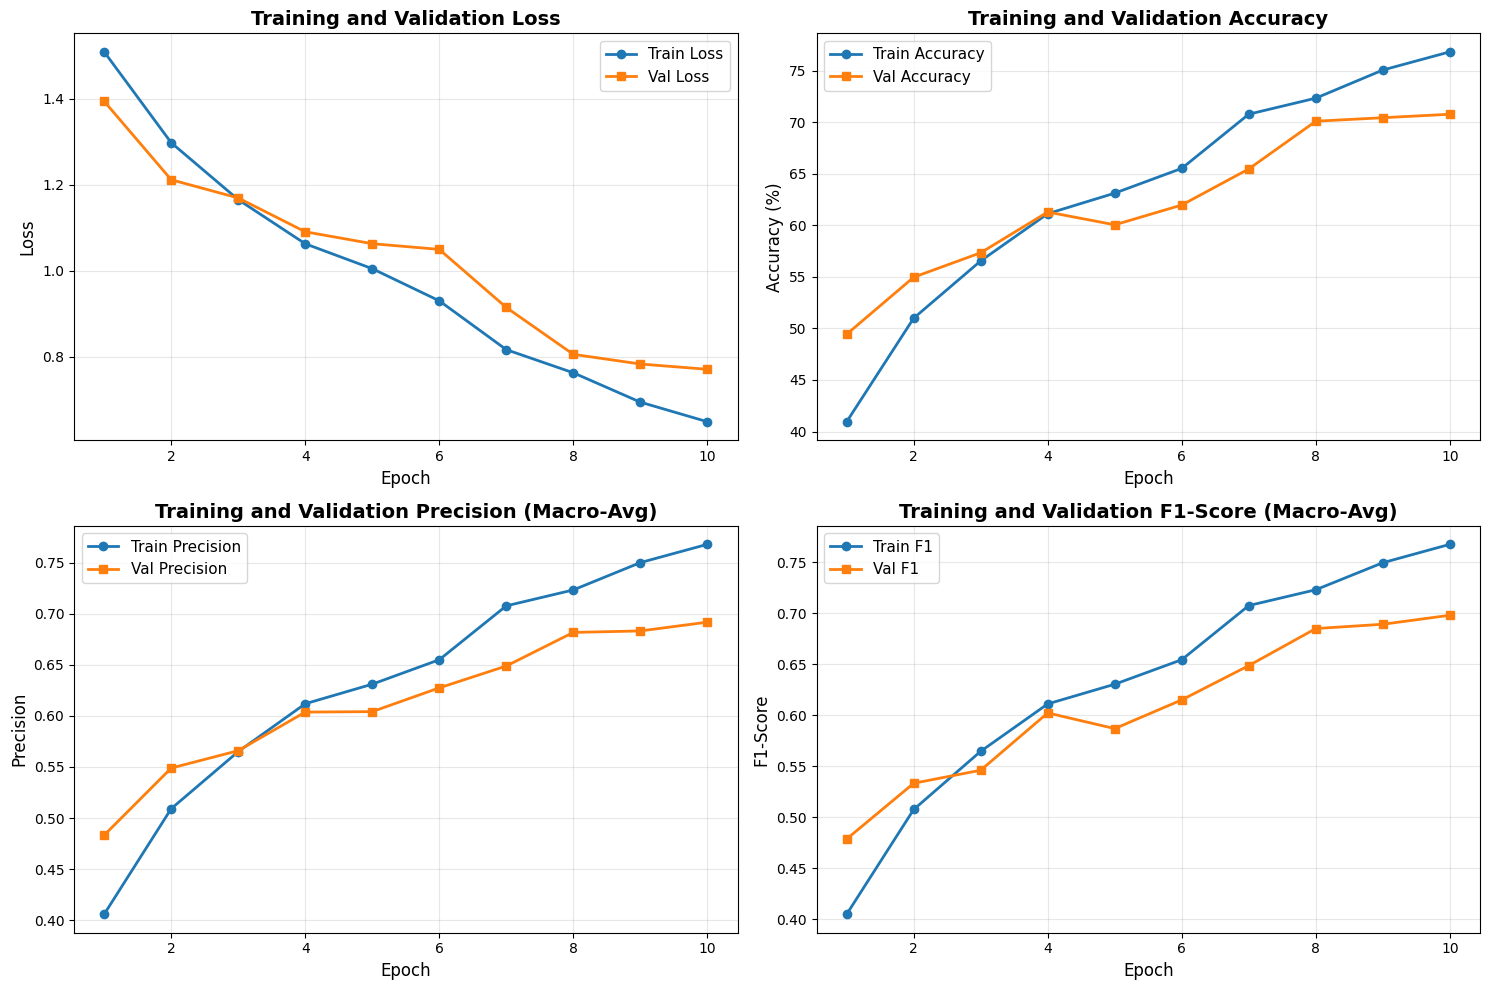


FINAL TRAINING SUMMARY
Best Validation Accuracy: 70.77%
Best Validation F1-Score: 0.6982

Final Epoch Metrics:
  Train -> Loss: 0.6493 | Acc: 76.82% | F1: 0.7678
  Val   -> Loss: 0.7711 | Acc: 70.77% | F1: 0.6982


In [21]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss over epochs
axes[0, 0].plot(results['epochs'], results['train_losses'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(results['epochs'], results['val_losses'], label='Val Loss', marker='s', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy over epochs
axes[0, 1].plot(results['epochs'], results['train_accuracies'], label='Train Accuracy', marker='o', linewidth=2)
axes[0, 1].plot(results['epochs'], results['val_accuracies'], label='Val Accuracy', marker='s', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Precision over epochs
axes[1, 0].plot(results['epochs'], results['train_precisions'], label='Train Precision', marker='o', linewidth=2)
axes[1, 0].plot(results['epochs'], results['val_precisions'], label='Val Precision', marker='s', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Training and Validation Precision (Macro-Avg)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: F1-Score over epochs
axes[1, 1].plot(results['epochs'], results['train_f1s'], label='Train F1', marker='o', linewidth=2)
axes[1, 1].plot(results['epochs'], results['val_f1s'], label='Val F1', marker='s', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('F1-Score', fontsize=12)
axes[1, 1].set_title('Training and Validation F1-Score (Macro-Avg)', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results summary
print(f"\n{'='*60}")
print("FINAL TRAINING SUMMARY")
print(f"{'='*60}")
print(f"Best Validation Accuracy: {results['best_acc']:.2f}%")
print(f"Best Validation F1-Score: {results['best_f1']:.4f}")
print(f"\nFinal Epoch Metrics:")
print(f"  Train -> Loss: {results['train_losses'][-1]:.4f} | Acc: {results['train_accuracies'][-1]:.2f}% | F1: {results['train_f1s'][-1]:.4f}")
print(f"  Val   -> Loss: {results['val_losses'][-1]:.4f} | Acc: {results['val_accuracies'][-1]:.2f}% | F1: {results['val_f1s'][-1]:.4f}")
print(f"{'='*60}")

# Step 19: Confusion Matrix Visualization

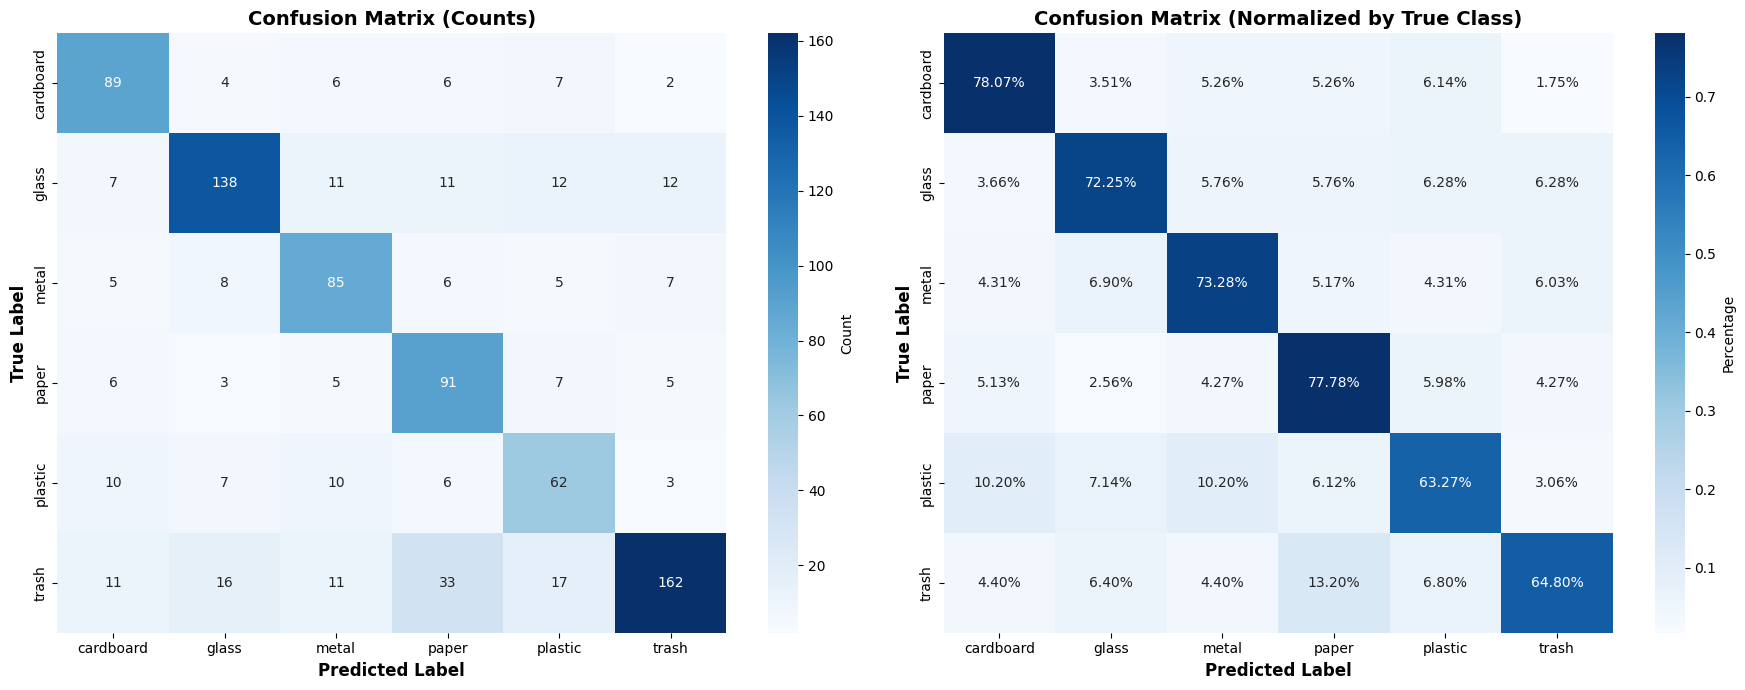


CLASSIFICATION REPORT (Validation Set)
              precision    recall  f1-score   support

   cardboard     0.6953    0.7807    0.7355       114
       glass     0.7841    0.7225    0.7520       191
       metal     0.6641    0.7328    0.6967       116
       paper     0.5948    0.7778    0.6741       117
     plastic     0.5636    0.6327    0.5962        98
       trash     0.8482    0.6480    0.7347       250

    accuracy                         0.7077       886
   macro avg     0.6917    0.7157    0.6982       886
weighted avg     0.7256    0.7077    0.7102       886


PER-CLASS METRICS SUMMARY
Class        Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
cardboard    0.6953       0.7807       0.7355       114       
glass        0.7841       0.7225       0.7520       191       
metal        0.6641       0.7328       0.6967       116       
paper        0.5948       0.7778       0.6741       117       
plas

In [22]:
# Evaluate final model on validation set to get predictions for confusion matrix
final_val_metrics = model_evaluation(model, val_loader, criterion, device)

# Create confusion matrix
cm = confusion_matrix(final_val_metrics['all_labels'], final_val_metrics['all_preds'])

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Raw counts confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix (Normalized by True Class)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT (Validation Set)")
print("="*70)
print(classification_report(final_val_metrics['all_labels'],
                          final_val_metrics['all_preds'],
                          target_names=classes,
                          digits=4))

# Print per-class metrics in a table format
print("\n" + "="*70)
print("PER-CLASS METRICS SUMMARY")
print("="*70)
print(f"{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-"*70)
for i, cls in enumerate(classes):
    print(f"{cls:<12} {final_val_metrics['per_class_precision'][i]:<12.4f} "
          f"{final_val_metrics['per_class_recall'][i]:<12.4f} "
          f"{final_val_metrics['per_class_f1'][i]:<12.4f} "
          f"{int(final_val_metrics['support'][i]):<10}")
print("-"*70)
print(f"{'Macro Avg':<12} {final_val_metrics['precision']:<12.4f} "
      f"{final_val_metrics['recall']:<12.4f} "
      f"{final_val_metrics['f1']:<12.4f} "
      f"{int(sum(final_val_metrics['support'])):<10}")
print("="*70)